In [1]:
# cell 02
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-wendy'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# cell 03
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

In [3]:
# cell 04
pd.__version__

'2.2.3'

In [4]:
# 加載數據
train_eccus = pd.read_csv('data/Train-ECCUS_Data_202412.csv')
train_id = pd.read_csv('data/Train-ID_Data_202412.csv')
train_accts = pd.read_csv('data/Train-ACCTS_Data_202412.csv')
train_sav_txn  = pd.read_csv('data/Train-SAV_TXN_Data_202412.csv')

In [5]:
# 以CUST_ID和ACCT_NBR為鍵合併帳戶資料與客戶資料
data = pd.merge(train_accts, train_id, on='CUST_ID', how='left')

# 合併交易資料
data = pd.merge(data, train_sav_txn, on=['ACCT_NBR', 'CUST_ID'], how='left')

# 合併警示資料
data = pd.merge(data, train_eccus, on=['CUST_ID', 'ACCT_NBR'], how='left')
data

,ACCT_NBR,CUST_ID,CANCEL_NO_CONTACT,IS_DIGITAL,ACCT_OPEN_DT,AUM_AMT,DATE_OF_BIRTH,YEARLYINCOMELEVEL,CNTY_CD,TX_DATE,...,CHANNEL_CODE,TRN_CODE,BRANCH_NO,EMP_NO,mb_check,eb_check,SAME_NUMBER_IP,SAME_NUMBER_UUID,DAY_OF_WEEK,DATA_DT
0,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18264,...,17,25,B111,E4445,0,0,0,0,Friday,NaN
1,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18278,...,10,6,B111,E4956,0,0,0,0,Friday,NaN
2,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,16,47,B111,E4956,0,0,0,0,Monday,NaN
3,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,17,25,B111,E4898,0,0,0,0,Monday,NaN
4,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,17,24,B112,E2590,0,0,0,0,Monday,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206328,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,17,25,B111,E4447,9,0,1,0,Wednesday,18286.0
206329,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,17,25,B111,E4915,9,0,1,0,Wednesday,18286.0
206330,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18284,...,17,25,B111,E4816,2,0,0,1,Thursday,18286.0
206331,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18285,...,17,25,B111,E4539,1,0,0,1,Friday,18286.0


In [6]:
# 1. 增加通報標記欄位
data['IS_REPORTED'] = 0  # 預設所有交易為未通報

# 2. 標記已通報交易
mask = pd.notna(data['DATA_DT'])
data.loc[mask, 'IS_REPORTED'] = np.where(
    data.loc[mask, 'TX_DATE'] >= data.loc[mask, 'DATA_DT'],
    1,  # 交易日期晚於或等於通報日期
    0   # 交易日期早於通報日期
)
data

,ACCT_NBR,CUST_ID,CANCEL_NO_CONTACT,IS_DIGITAL,ACCT_OPEN_DT,AUM_AMT,DATE_OF_BIRTH,YEARLYINCOMELEVEL,CNTY_CD,TX_DATE,...,TRN_CODE,BRANCH_NO,EMP_NO,mb_check,eb_check,SAME_NUMBER_IP,SAME_NUMBER_UUID,DAY_OF_WEEK,DATA_DT,IS_REPORTED
0,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18264,...,25,B111,E4445,0,0,0,0,Friday,NaN,0
1,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18278,...,6,B111,E4956,0,0,0,0,Friday,NaN,0
2,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,47,B111,E4956,0,0,0,0,Monday,NaN,0
3,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,25,B111,E4898,0,0,0,0,Monday,NaN,0
4,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,24,B112,E2590,0,0,0,0,Monday,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206328,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,25,B111,E4447,9,0,1,0,Wednesday,18286.0,0
206329,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,25,B111,E4915,9,0,1,0,Wednesday,18286.0,0
206330,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18284,...,25,B111,E4816,2,0,0,1,Thursday,18286.0,0
206331,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18285,...,25,B111,E4539,1,0,0,1,Friday,18286.0,0


In [7]:
reported_transactions = data[data['IS_REPORTED'] == 1]
print("已通報交易數量:", len(reported_transactions))
print("\n已通報交易前5筆:")
reported_transactions.head()

已通報交易數量: 1604

已通報交易前5筆:


,ACCT_NBR,CUST_ID,CANCEL_NO_CONTACT,IS_DIGITAL,ACCT_OPEN_DT,AUM_AMT,DATE_OF_BIRTH,YEARLYINCOMELEVEL,CNTY_CD,TX_DATE,...,TRN_CODE,BRANCH_NO,EMP_NO,mb_check,eb_check,SAME_NUMBER_IP,SAME_NUMBER_UUID,DAY_OF_WEEK,DATA_DT,IS_REPORTED
196428,ACCT14280,ID13531,1,0,16037,18571,24,25.0,12.0,18278,...,6,B111,E4956,0,0,0,0,Friday,18265.0,1
196496,ACCT764,ID713,0,0,18059,14590,29,25.0,12.0,18263,...,24,B9,E1118,0,0,1,0,Thursday,18263.0,1
196497,ACCT764,ID713,0,0,18059,14590,29,25.0,12.0,18263,...,24,B112,E3174,0,0,1,0,Thursday,18263.0,1
196498,ACCT764,ID713,0,0,18059,14590,29,25.0,12.0,18263,...,24,B2,E3116,0,0,1,0,Thursday,18263.0,1
196499,ACCT764,ID713,0,0,18059,14590,29,25.0,12.0,18263,...,24,B2,E2575,0,0,1,0,Thursday,18263.0,1



特徵 CUST_ID 有太多唯一值，顯示統計摘要
Top 10 類別（目標值=1的比例最高）:
CUST_ID
ID28594    1.0
ID15688    1.0
ID720      1.0
ID21680    1.0
ID17673    1.0
ID10364    1.0
ID8094     1.0
ID132      1.0
ID23220    1.0
ID28089    1.0
Name: IS_REPORTED, dtype: float64

特徵 ACCT_NBR 有太多唯一值，顯示統計摘要
Top 10 類別（目標值=1的比例最高）:
ACCT_NBR
ACCT16988    1.0
ACCT30112    1.0
ACCT24465    1.0
ACCT16090    1.0
ACCT139      1.0
ACCT2899     1.0
ACCT6210     1.0
ACCT19923    1.0
ACCT4868     1.0
ACCT29576    1.0
Name: IS_REPORTED, dtype: float64

特徵 TX_DATE 有太多唯一值，顯示統計摘要
Top 10 類別（目標值=1的比例最高）:
TX_DATE
18273    0.014710
18276    0.014510
18283    0.013432
18274    0.013005
18278    0.012705
18287    0.012608
18285    0.011438
18289    0.011156
18267    0.010529
18261    0.009796
Name: IS_REPORTED, dtype: float64

分析類別特徵：TX_TIME
IS_REPORTED         0         1
TX_TIME                        
0            0.050872  0.069825
1            0.010922  0.033042
2            0.070083  0.009975
3            0.021717  0.006858
4            0.12

<Figure size 1000x600 with 0 Axes>

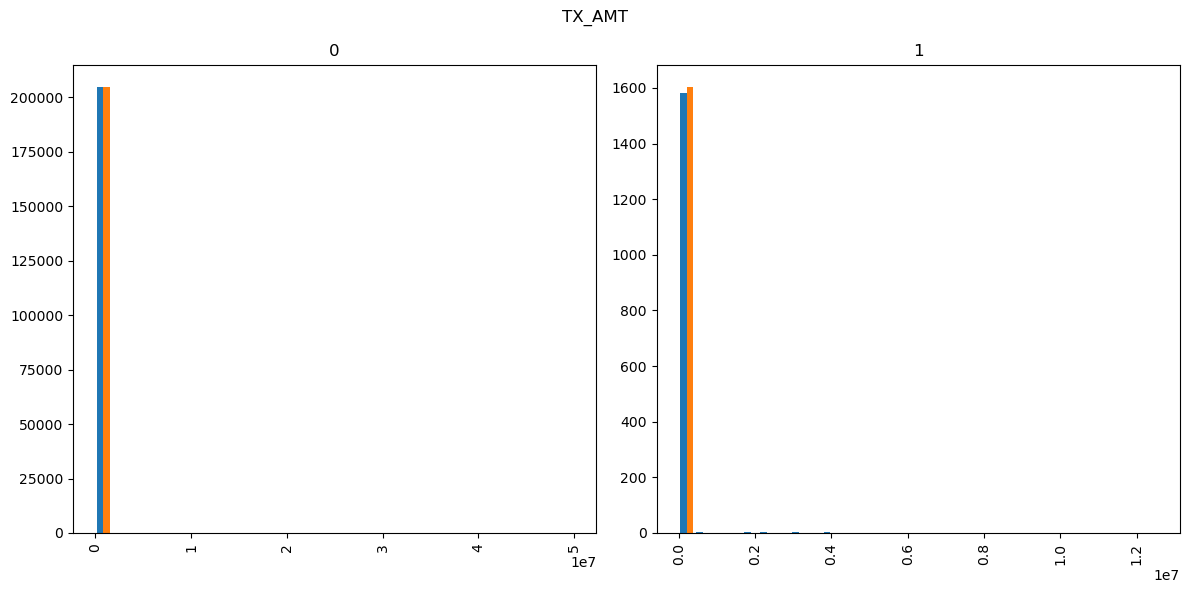


分析數值特徵：PB_BAL


<Figure size 1000x600 with 0 Axes>

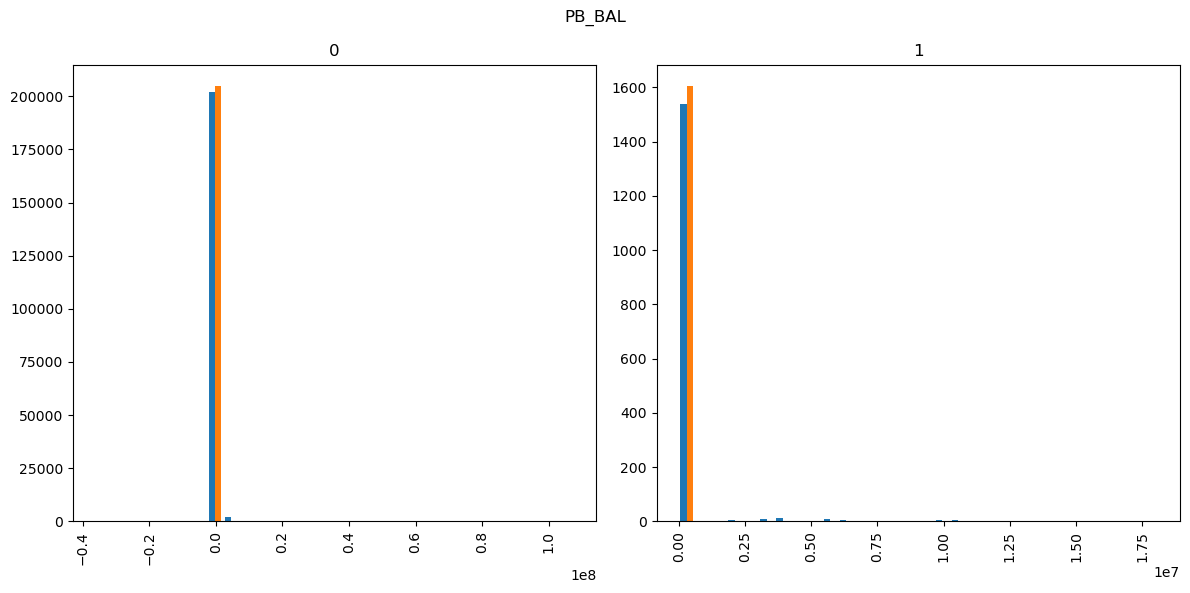


分析數值特徵：DRCR


<Figure size 1000x600 with 0 Axes>

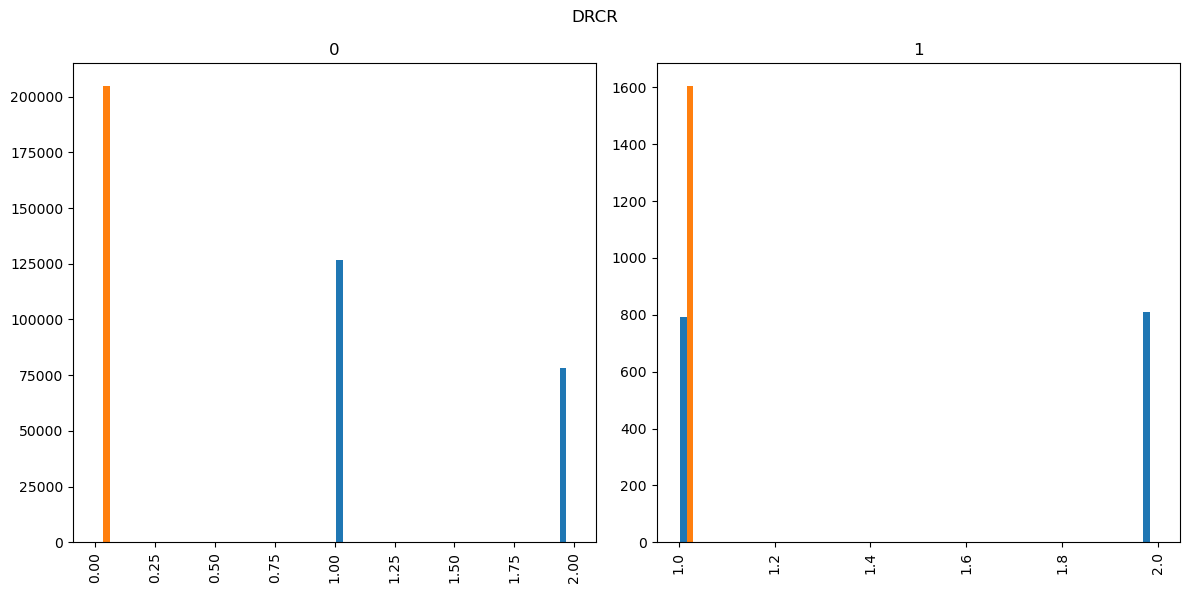


分析數值特徵：mb_check


<Figure size 1000x600 with 0 Axes>

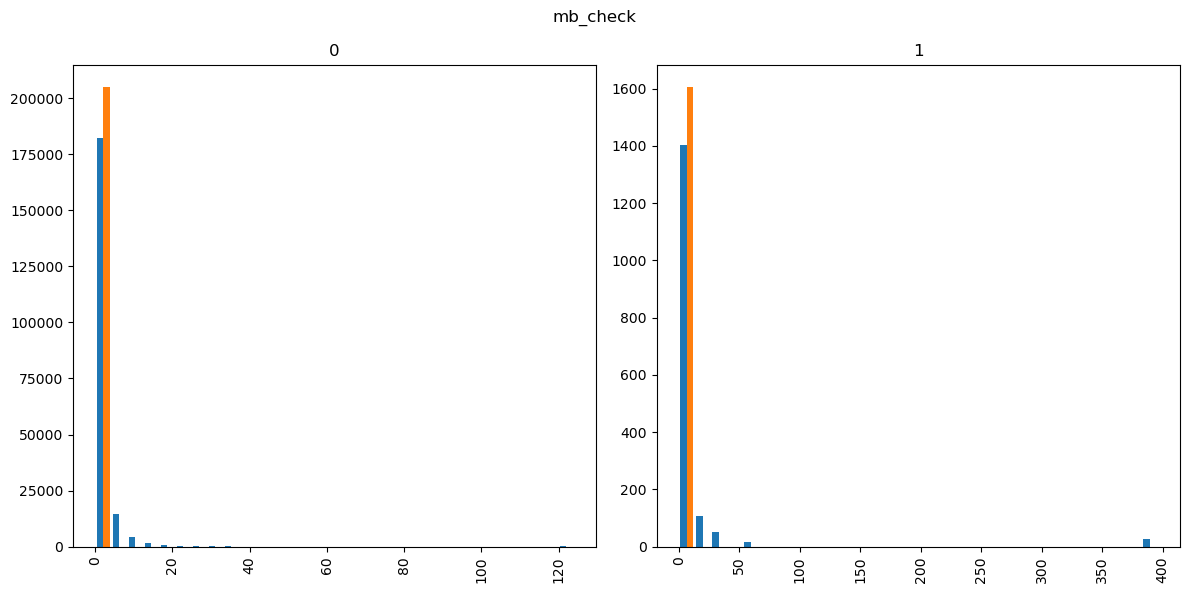


分析數值特徵：eb_check


<Figure size 1000x600 with 0 Axes>

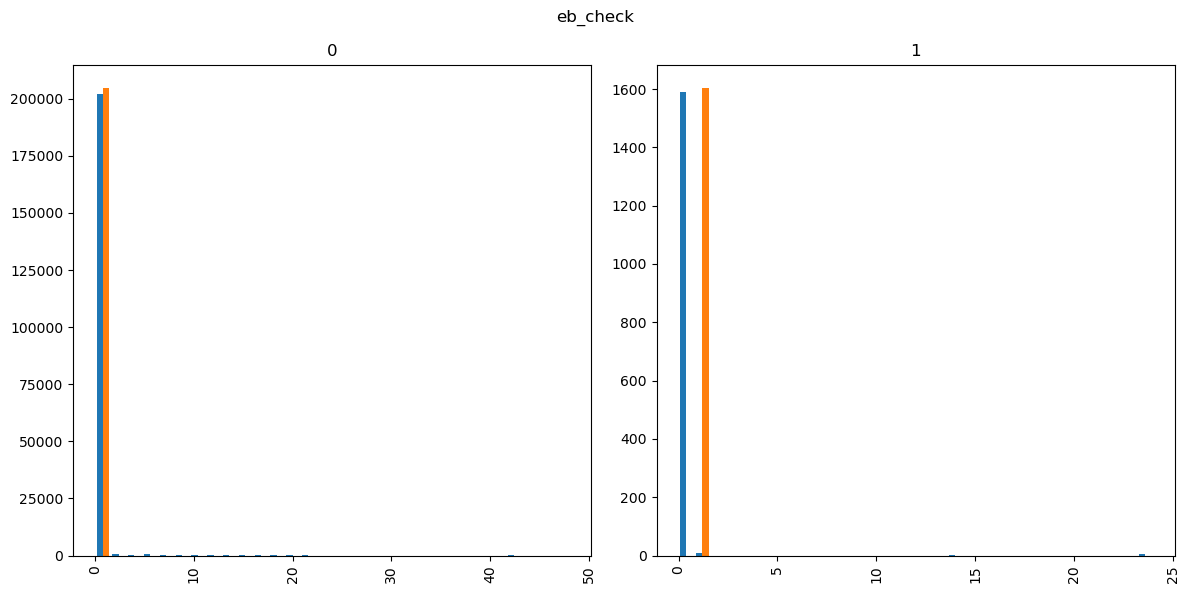


分析數值特徵：SAME_NUMBER_IP


<Figure size 1000x600 with 0 Axes>

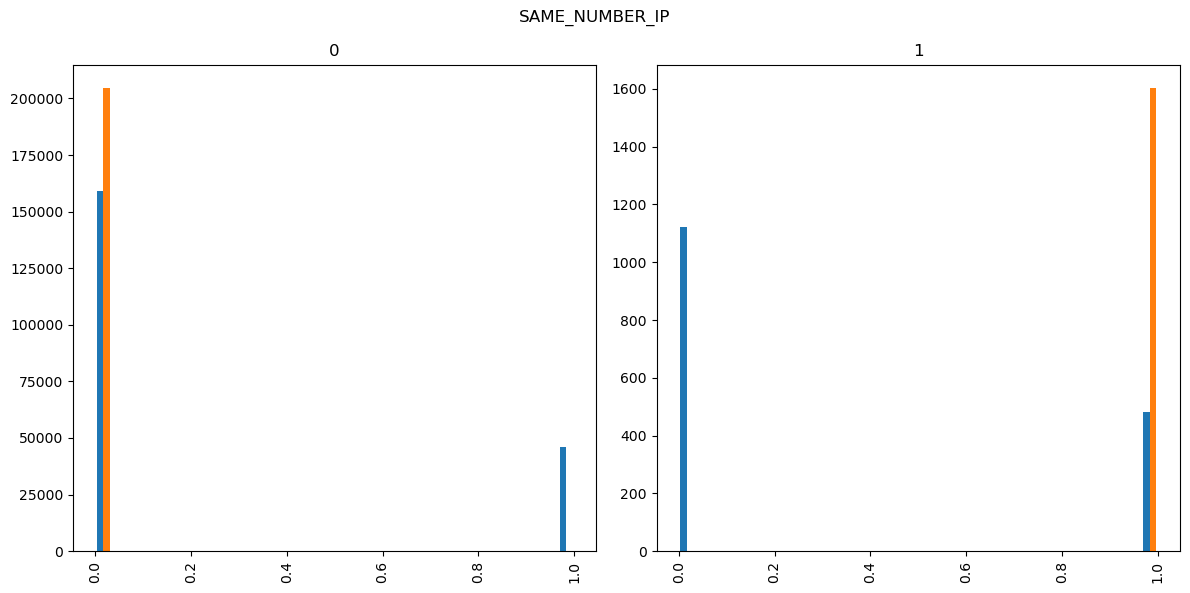


分析數值特徵：SAME_NUMBER_UUID


<Figure size 1000x600 with 0 Axes>

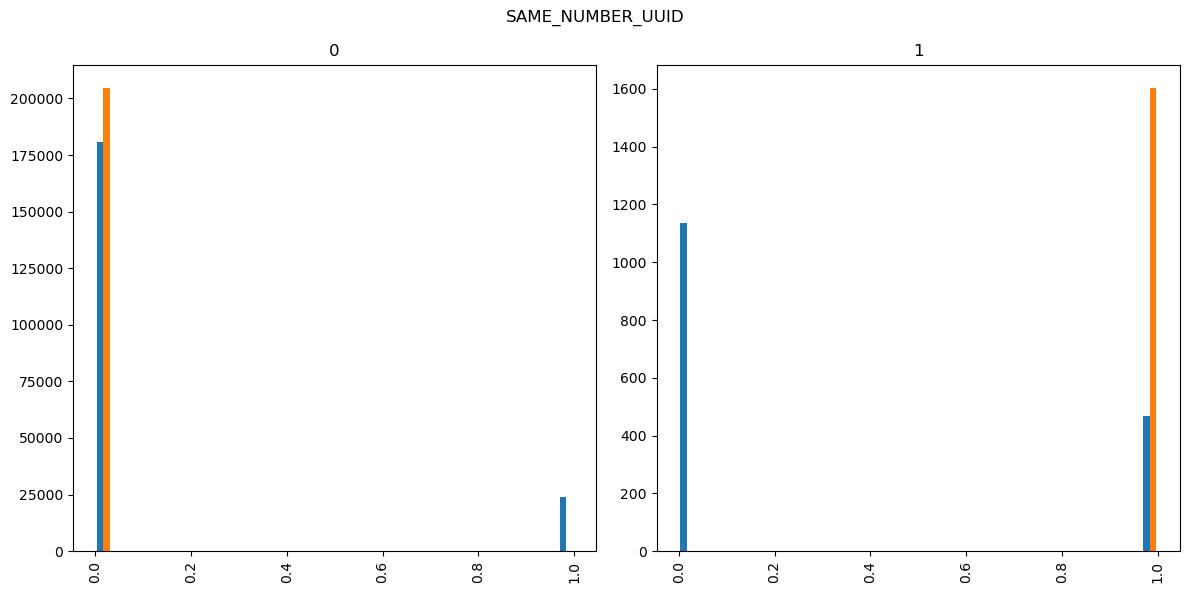


分析數值特徵：CANCEL_NO_CONTACT


<Figure size 1000x600 with 0 Axes>

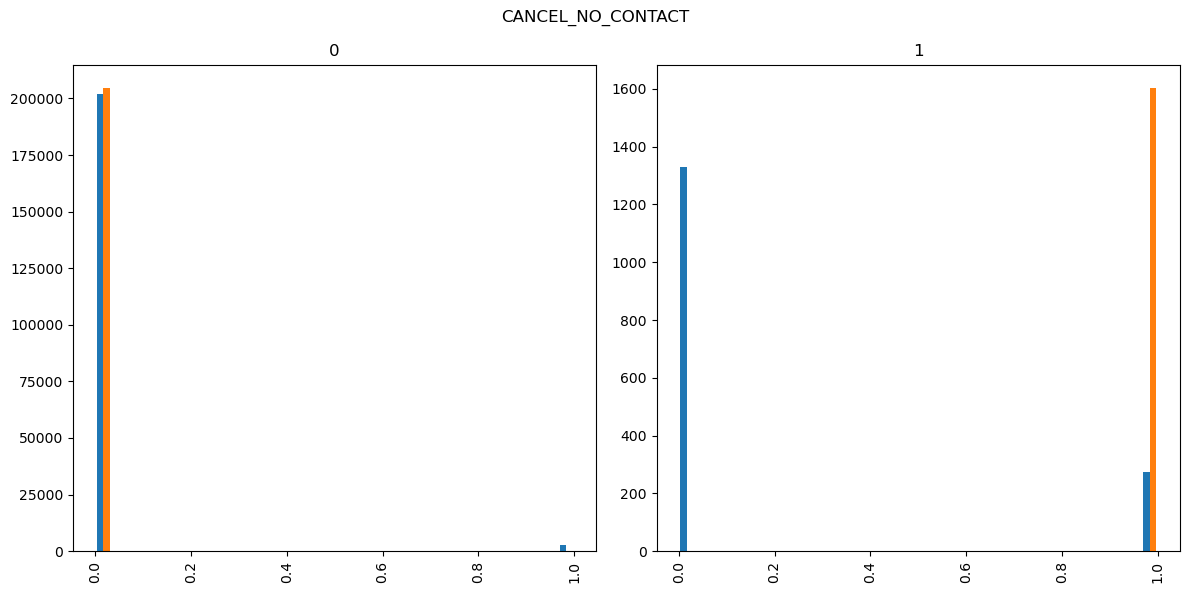


分析數值特徵：IS_DIGITAL


<Figure size 1000x600 with 0 Axes>

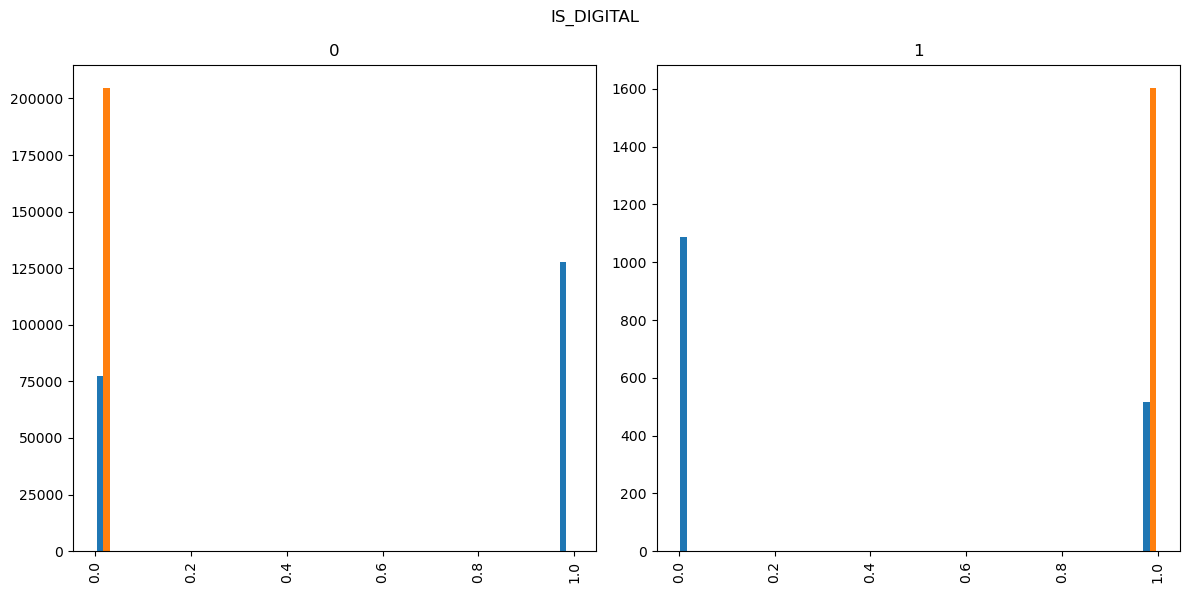


分析數值特徵：YEARLYINCOMELEVEL


<Figure size 1000x600 with 0 Axes>

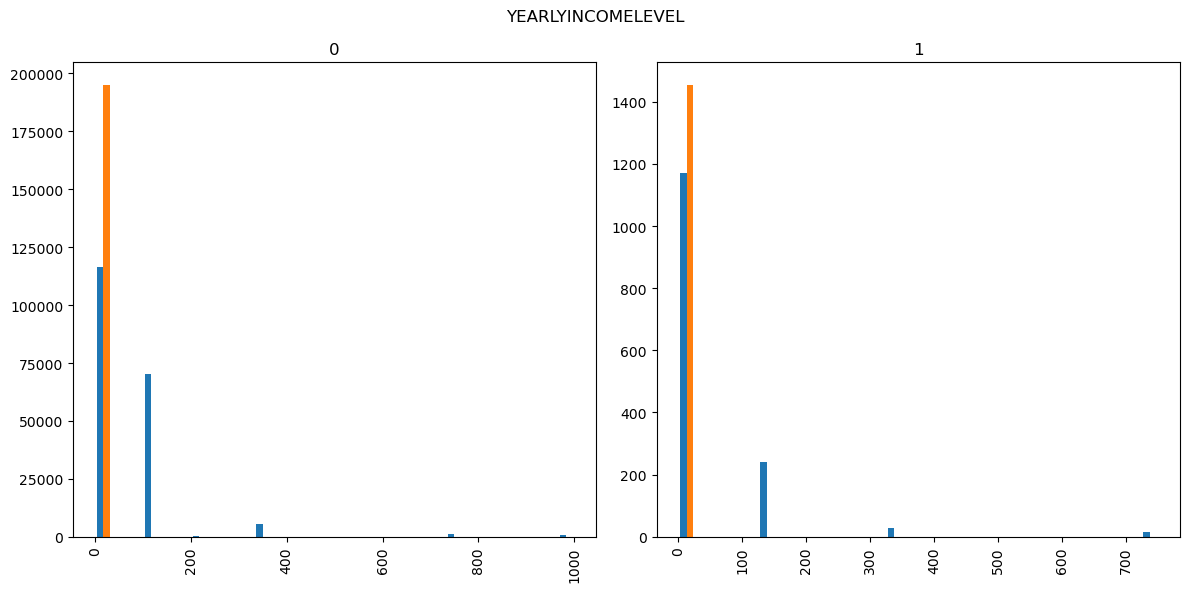


分析數值特徵：AUM_AMT


<Figure size 1000x600 with 0 Axes>

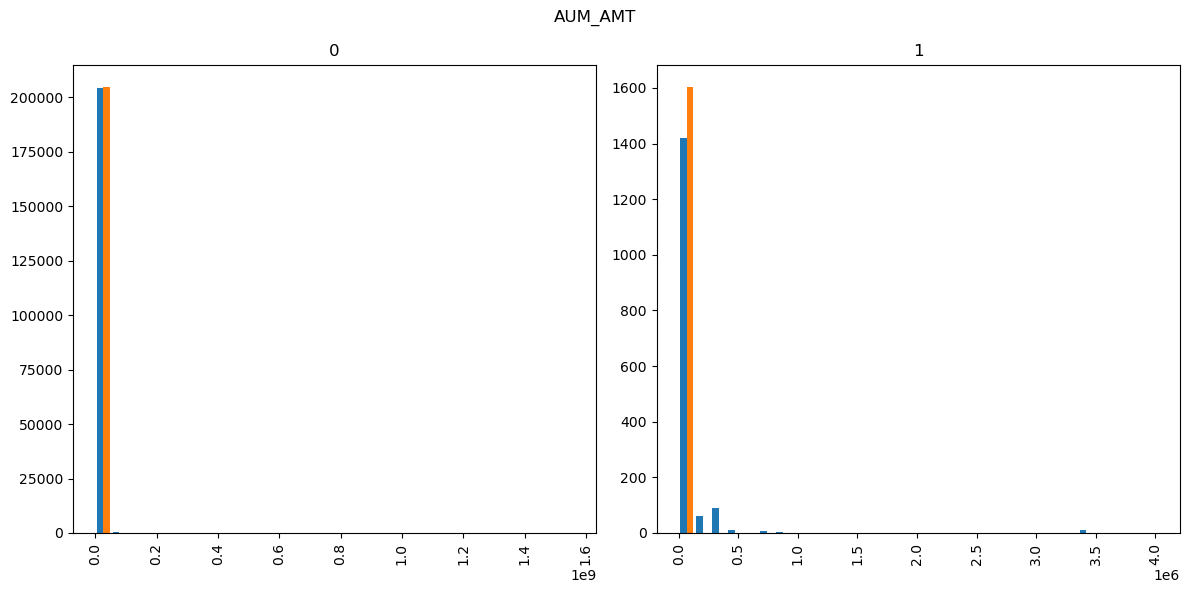

In [8]:
category_columns = ['CUST_ID', 'ACCT_NBR', 'TX_DATE', 'TX_TIME', 'OWN_TRANS_ACCT', 
                   'OWN_TRANS_ID', 'CHANNEL_CODE', 'TRN_CODE', 'BRANCH_NO', 'EMP_NO', 
                   'DATE_OF_BIRTH', 'CNTY_CD', 'DATA_DT', 'ACCT_OPEN_DT', 'DAY_OF_WEEK']
numeric_columns = ['TX_AMT', 'PB_BAL', 'DRCR', 'mb_check', 'eb_check', 'SAME_NUMBER_IP', 
                  'SAME_NUMBER_UUID', 'CANCEL_NO_CONTACT', 'IS_DIGITAL', 'YEARLYINCOMELEVEL', 'AUM_AMT']

# 將目標變數名稱從'y'改為實際名稱'CANCEL_NO_CONTACT'
target = 'IS_REPORTED'

# 1. 分析類別型特徵與目標變數的關係
for column in category_columns:
    if column != target and column in data.columns:
        # 處理高基數特徵
        if data[column].nunique() > 30:
            print(f"\n特徵 {column} 有太多唯一值，顯示統計摘要")
            target_stats = data.groupby(column)[target].mean().sort_values(ascending=False)
            print("Top 10 類別（目標值=1的比例最高）:")
            print(target_stats.head(10))
        else:
            print(f"\n分析類別特徵：{column}")
            ct = pd.crosstab(index=data[column], columns=data[target], normalize='columns')
            print(ct)

# 2. 分析數值型特徵與目標變數的關係
for column in numeric_columns:
    if column != target and column in data.columns:
        print(f"\n分析數值特徵：{column}")
        plt.figure(figsize=(10, 6))
        hist = data[[column, target]].hist(by=target, bins=30, figsize=(12, 6))
        plt.suptitle(column)
        plt.tight_layout()
        plt.show()

In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
import seaborn as sns

# 3. 計算數值特徵間的相關係數矩陣
print("\n數值特徵相關係數矩陣:")
print(data.corr(numeric_only=True))
# pd.plotting.scatter_matrix(data, figsize=(20,20))
# plt.show()


數值特徵相關係數矩陣:
                   CANCEL_NO_CONTACT  IS_DIGITAL  ACCT_OPEN_DT   AUM_AMT  \
CANCEL_NO_CONTACT           1.000000   -0.094871     -0.069130 -0.006685   
IS_DIGITAL                 -0.094871    1.000000      0.484926 -0.080019   
ACCT_OPEN_DT               -0.069130    0.484926      1.000000 -0.096886   
AUM_AMT                    -0.006685   -0.080019     -0.096886  1.000000   
DATE_OF_BIRTH               0.032520   -0.344394     -0.579170  0.107852   
YEARLYINCOMELEVEL          -0.024282   -0.132819     -0.228645  0.268111   
CNTY_CD                    -0.020531    0.049232     -0.025307  0.002737   
TX_DATE                     0.000476   -0.018203     -0.030275  0.012328   
TX_TIME                     0.034977    0.070365      0.029353 -0.036706   
DRCR                        0.029611   -0.106791     -0.086695  0.028603   
TX_AMT                      0.011715   -0.047478     -0.051280  0.020903   
PB_BAL                     -0.003882   -0.135983     -0.184942  0.142826   

In [11]:
data

,ACCT_NBR,CUST_ID,CANCEL_NO_CONTACT,IS_DIGITAL,ACCT_OPEN_DT,AUM_AMT,DATE_OF_BIRTH,YEARLYINCOMELEVEL,CNTY_CD,TX_DATE,...,TRN_CODE,BRANCH_NO,EMP_NO,mb_check,eb_check,SAME_NUMBER_IP,SAME_NUMBER_UUID,DAY_OF_WEEK,DATA_DT,IS_REPORTED
0,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18264,...,25,B111,E4445,0,0,0,0,Friday,NaN,0
1,ACCT6068,ID5684,0,0,8400,256930,61,25.0,12.0,18278,...,6,B111,E4956,0,0,0,0,Friday,NaN,0
2,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,47,B111,E4956,0,0,0,0,Monday,NaN,0
3,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,25,B111,E4898,0,0,0,0,Monday,NaN,0
4,ACCT11459,ID10838,0,0,9569,65,57,NaN,12.0,18260,...,24,B112,E2590,0,0,0,0,Monday,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206328,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,25,B111,E4447,9,0,1,0,Wednesday,18286.0,0
206329,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18283,...,25,B111,E4915,9,0,1,0,Wednesday,18286.0,0
206330,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18284,...,25,B111,E4816,2,0,0,1,Thursday,18286.0,0
206331,ACCT16300,ID15460,0,1,16254,24430,36,25.0,12.0,18285,...,25,B111,E4539,1,0,0,1,Friday,18286.0,0


In [12]:
time_columns = ['TX_DATE', 'ACCT_OPEN_DT', 'DATA_DT','TX_TIME','DATE_OF_BIRTH']

for col in time_columns:
    if col in data.columns:
        # 轉成數值型態，無效值轉為NaN
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 填補 NaN
for col in time_columns:
    if col in data.columns:
        nan_count = data[col].isna().sum()
        if nan_count > 0:
            # 找到該欄最大日期序號（忽略NaN）
            max_date = data[col].max()
            # 或根據業務規則填一個指定值，如 0、-1等
            fill_value = max_date + 0
            data[col] = data[col].fillna(fill_value)
            print(f"{col} 欄位有 {nan_count} 個空值，已填為 {fill_value}")

# 最終檢查
print(data[time_columns].info())

DATA_DT 欄位有 196360 個空值，已填為 18289.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206333 entries, 0 to 206332
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TX_DATE        206333 non-null  int64  
 1   ACCT_OPEN_DT   206333 non-null  int64  
 2   DATA_DT        206333 non-null  float64
 3   TX_TIME        206333 non-null  int64  
 4   DATE_OF_BIRTH  206333 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 7.9 MB
None


In [13]:
def time_series_split_with_account_integrity(model_data):
    # 1. 按交易日期排序
    model_data = model_data.sort_values('TX_DATE').reset_index(drop=True)

    # 2. 找出時間分割點
    train_end_date = model_data['TX_DATE'].quantile(0.7)
    val_end_date = model_data['TX_DATE'].quantile(0.9)

    # 3. 識別每個分割區間中的獨特帳戶
    train_accounts = model_data[model_data['TX_DATE'] <= train_end_date]['ACCT_NBR'].unique()
    remaining_accounts = model_data[model_data['TX_DATE'] > train_end_date]['ACCT_NBR'].unique()

    # 4. 處理交叉帳戶：將所有分割點附近出現在多個時間段的帳戶重新分配
    cross_accounts = np.intersect1d(train_accounts, remaining_accounts)

    # 5. 將交叉帳戶分配到其大部分交易所在的區間
    for account in cross_accounts:
        account_data = model_data[model_data['ACCT_NBR'] == account]
        count_train = (account_data['TX_DATE'] <= train_end_date).sum()
        count_val_test = (account_data['TX_DATE'] > train_end_date).sum()
        if count_train >= count_val_test:
            # 將該帳戶全部交易分配到訓練集
            train_accounts = np.append(train_accounts, account)
            remaining_accounts = remaining_accounts[remaining_accounts != account]
        else:
            # 將該帳戶全部交易分配到驗證/測試集
            remaining_accounts = np.append(remaining_accounts, account)
            train_accounts = train_accounts[train_accounts != account]

    # 6. 計算驗證集帳戶（剩餘帳戶中再分割）
    val_accounts = remaining_accounts[:int(0.5 * len(remaining_accounts))]
    test_accounts = remaining_accounts[int(0.5 * len(remaining_accounts)):]

    # 7. 根據帳戶分配建立資料集
    train_data = model_data[model_data['ACCT_NBR'].isin(train_accounts)]
    validation_data = model_data[model_data['ACCT_NBR'].isin(val_accounts)]
    test_data = model_data[model_data['ACCT_NBR'].isin(test_accounts)]

    # 8. 輸出資料集大小
    print(f"訓練集帳戶數: {len(train_accounts)} 帳戶，{len(train_data)} 筆交易")
    print(f"驗證集帳戶數: {len(val_accounts)} 帳戶，{len(validation_data)} 筆交易")
    print(f"測試集帳戶數: {len(test_accounts)} 帳戶，{len(test_data)} 筆交易")

    return train_data, validation_data, test_data

In [14]:
# 2. 標記識別欄位
id_cols = ['CUST_ID', 'ACCT_NBR','OWN_TRANS_ACCT', 'OWN_TRANS_ID', 'BRANCH_NO', 'EMP_NO']

# 3. 標記需要 one-hot 的類別欄位（不含識別欄位）
categorical_cols = [
    'CHANNEL_CODE', 'TRN_CODE', 'DAY_OF_WEEK', 'CNTY_CD',
    'YEARLYINCOMELEVEL'
]

# 4. one-hot 編碼（保留識別欄位）
data_encoded = pd.get_dummies(data, columns=categorical_cols, dtype=float)

In [ ]:
# 5. 執行你的切分函數
train_data, val_data, test_data = time_series_split_with_account_integrity(data_encoded)

# 6. 切分後，針對每個資料集移除識別欄位，僅保留數值特徵
def drop_id_cols(df):
    return df.drop(columns=id_cols, errors='ignore')

X_train = drop_id_cols(train_data)
X_val = drop_id_cols(val_data)
X_test = drop_id_cols(test_data)

In [ ]:
print(list(X_train.columns))
print(len(X_train.columns))

In [ ]:
# 將訓練集轉換為SageMaker XGBoost所需的CSV格式
# IS_REPORTED作為第一列，其他所有特徵列跟隨
pd.concat([X_train['IS_REPORTED'], X_train.drop(['IS_REPORTED'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)

# 將驗證集轉換為SageMaker XGBoost所需的CSV格式
pd.concat([X_val['IS_REPORTED'], X_val.drop(['IS_REPORTED'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [ ]:
print(list(X_train.columns))
print(len(X_train.columns))

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [ ]:
# XGBoost 寫法
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [ ]:
# 檢查CSV檔案格式
!head -n 5 train.csv

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.c5.2xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

In [ ]:
# cell 18
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.c5.2xlarge')

In [ ]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:
# cell 20
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(X_test.drop(['IS_REPORTED'], axis=1).to_numpy(), xgb_predictor)

In [ ]:
from sklearn.metrics import f1_score

# y_true: 實際標籤
y_true = X_test['IS_REPORTED'].values

# y_pred: 預測結果（機率需轉0/1）
y_pred = np.round(predictions)

# 計算F1-score
f1 = f1_score(y_true, y_pred)
print(f'F1-score: {f1:.4f}')

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)


In [ ]:
# xgb_predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
test_id = pd.read_csv('test_data/(Test)ID_Data_202501.csv')
test_accts = pd.read_csv('test_data/(Test)ACCTS_Data_202501.csv')
test_sav_txn  = pd.read_csv('test_data/(Test)SAV_TXN_Data_202501.csv')

In [ ]:
# 以CUST_ID和ACCT_NBR為鍵合併帳戶資料與客戶資料
test_df = pd.merge(test_accts, test_id, on='CUST_ID', how='left')

# 合併交易資料
test_df = pd.merge(test_df, test_sav_txn, on=['ACCT_NBR', 'CUST_ID'], how='left')
test_df

In [ ]:
# 2. 數值欄位轉型
time_columns = ['TX_DATE', 'ACCT_OPEN_DT','TX_TIME','DATE_OF_BIRTH']
for col in time_columns:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce').fillna(0)

# 3. 標記需要 one-hot 的類別欄位（不含識別欄位）
categorical_cols = [
    'CHANNEL_CODE', 'TRN_CODE', 'DAY_OF_WEEK', 'CNTY_CD', 'YEARLYINCOMELEVEL'
]

# 4. one-hot 編碼（保留識別欄位）
data_encoded = pd.get_dummies(test_df, columns=categorical_cols, dtype=float)
# 4. 排除識別欄位
id_cols = ['CUST_ID', 'ACCT_NBR','OWN_TRANS_ACCT', 'OWN_TRANS_ID', 'BRANCH_NO', 'EMP_NO']
test_features = data_encoded.drop(columns=id_cols, errors='ignore')
test_features

In [ ]:
print(list(test_features.columns))
print(len(test_features.columns))

In [ ]:
# # 5. 特徵對齊（必須與訓練時一致）
# # 載入訓練時的特徵欄位順序
train_feature_list = list(X_train.columns)  # 必須與訓練時完全一致
test_features = test_features.reindex(columns=train_feature_list, fill_value=-1)
test_features

In [ ]:
# 6. 取出標籤
X_test = test_features.drop(columns=['IS_REPORTED'], errors='ignore').to_numpy(dtype=float)

In [ ]:
def sagemaker_batch_predict(X_test, endpoint_name, batch_size=500):
    runtime = boto3.client('sagemaker-runtime', region_name='us-west-2')
    all_preds = []
    n = X_test.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = X_test[start:end]
        csv_buffer = io.StringIO()
        pd.DataFrame(batch).to_csv(csv_buffer, header=False, index=False)
        payload = csv_buffer.getvalue()
        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=payload
        )
        result = response['Body'].read().decode('utf-8')
        preds = np.fromstring(result, sep=',')
        all_preds.append(preds)
    return np.concatenate(all_preds)

# 使用方式
endpoint_name = 'xgboost-2025-04-27-04-11-10-831'
# 假設 X_test 是 numpy array 或 DataFrame
y_pred = sagemaker_batch_predict(X_test, endpoint_name, batch_size=500)
print(len(y_pred))

In [ ]:
print(len(test_sav_txn))

In [ ]:
# 2. 加入預測結果
test_sav_txn['pred_label'] = y_pred.astype(int)  # y_pred為模型預測結果，長度需與test_df一致

# 3. 彙總警示帳戶（只要有一筆預測為1即為警示帳戶）
alert_accounts = set(test_sav_txn.loc[test_sav_txn['pred_label'] == 1, 'ACCT_NBR'])

# 4. 讀取答案檔
ans_df = pd.read_csv('test_data/(Test)ANS_202501.csv')

# 5. 標註Y欄位（警示帳戶標1，否則0）
ans_df['Y'] = ans_df['ACCT_NBR'].apply(lambda x: 1 if x in alert_accounts else 0)

# 6. 輸出新檔
ans_df.to_csv('(Test)ANS_202501_with_alert.csv', index=False)
print('標註完成，已輸出 (Test)ANS_202501_with_alert.csv')


In [ ]:
test_df